In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

import numpy as np
import math, random
import pandas as pd

from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
import torch.utils.data
import torch.optim 
from torch.optim import lr_scheduler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from makesig import *
from utils import *

In [2]:
%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-08-31 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.1
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 95%


In [3]:
# Hyperparameters
HP = HYPERPARAMETERS({
    'NUM_HIDDEN_NODES'    : 95 ,
    'NUM_EXAMPLES'        : 100000 ,
    'TRAIN_SPLIT'         : .8 ,
    'MINI_BATCH_SIZE'     : 200 ,
    'NUM_EPOCHS'          : 600 ,
    'LEARNING_RATE'       : 5e-5 ,
    'LEARNING_RATE_DECAY' : 500 ,
    'WEIGHT_DECAY'        : 5e-4 ,
    'NUM_MOMENTUM'        : 0.9 ,
    'SEED'                : 2018
})

#  torch.cuda.is_available = lambda : False            # uncomment if you want to switch GPU support off

In [4]:
# Seed random generators for repro 
np.random.seed(HP.SEED)  
torch.manual_seed(HP.SEED);
if torch.cuda.is_available():
    torch.cuda.manual_seed(HP.SEED)

In [5]:
x_data = np.float32(np.random.uniform(-4*math.pi, 4*math.pi, (1, HP.NUM_EXAMPLES))).T
function_to_learn = lambda x: np.sin(x) + 0.1*np.random.randn(*x.shape)

# x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, HP.NUM_EXAMPLES))).T
# function_to_learn = lambda x: np.sin(0.75*x)*7.0 + x*0.5 + 0.1*np.random.randn(*x.shape)

# x_data = np.float32(np.random.uniform(-2*math.pi, 2*math.pi, (1, HP.NUM_EXAMPLES))).T
# function_to_learn = lambda x: np.cos(x) + 0.1*np.random.randn(*x.shape)

# x_data = np.float32(np.random.uniform(-1, 1, (1, HP.NUM_EXAMPLES))).T #, endpoint=False))
# function_to_learn = lambda x: np.cos(2 * np.pi * 7 * x) + signal.gausspulse(x - 0.4, fc=2)

# x_data = np.float32(torch.unsqueeze(torch.linspace(-1, 1, HP.NUM_EXAMPLES), dim=1).numpy())
# function_to_learn = lambda x: x**2# + 0.2*np.random.randn(*x.shape)

y_data = function_to_learn(x_data)

In [6]:
# from tslearn.generators import random_walks
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance
# from tslearn import metrics
# import random

# dataset = random_walks(n_ts=1, sz=HP.NUM_EXAMPLES, d=1)
# scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
# y_data = scaler.fit_transform(dataset).flatten()
# x_data = np.divide(np.arange(HP.NUM_EXAMPLES), HP.NUM_EXAMPLES)

In [7]:
# random shuffle data
idx = np.arange(HP.NUM_EXAMPLES)
np.random.shuffle(idx)
train_idx, validate_idx, test_idx = np.split(idx, [int(.6*len(idx)), int(.8*len(idx))]) #60%, 20%, 20% split 

x_data = np.float32(x_data).reshape(HP.NUM_EXAMPLES, 1)
y_data = np.float32(y_data).reshape(HP.NUM_EXAMPLES, 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit_transform(y_data[train_idx]) # fit scaler on trainings data 
y_data = scaler.fit_transform(y_data)

train_x, train_y = x_data[train_idx], y_data[train_idx]
train_set = torch.utils.data.TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=HP.MINI_BATCH_SIZE, shuffle=True, 
                                           pin_memory=True, num_workers=0)

valid_x, valid_y  = x_data[validate_idx], y_data[validate_idx]
valid_set = torch.utils.data.TensorDataset(torch.FloatTensor(valid_x), torch.FloatTensor(valid_y))
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=HP.MINI_BATCH_SIZE, shuffle=True, 
                                           pin_memory=True, num_workers=0)

test_x, test_y  = x_data[test_idx], y_data[test_idx]
test_set = torch.utils.data.TensorDataset(torch.FloatTensor(test_x), torch.FloatTensor(test_x))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=False, num_workers=0)

train_x.shape, valid_x.shape, test_x.shape, train_y.shape, valid_y.shape, test_y.shape

((60000, 1), (20000, 1), (20000, 1), (60000, 1), (20000, 1), (20000, 1))

,x,y
count,60000.000000,60000.000000
mean,0.010107,-0.009938
std,7.245897,0.512204
min,-12.566225,-1.000000
25%,-6.256293,-0.513290
50%,0.018838,-0.004515
75%,6.291377,0.491501
max,12.565879,1.000000


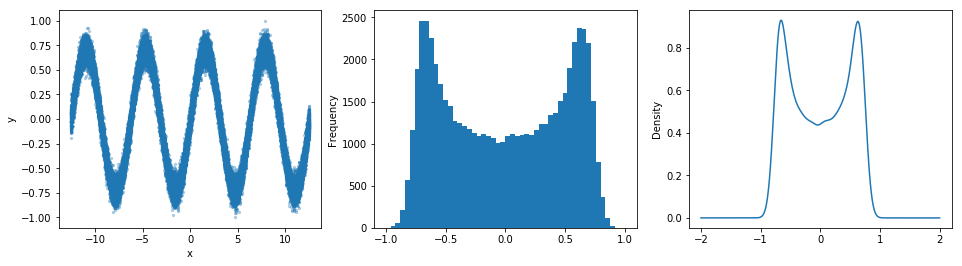

In [8]:
df = DataFrame({'x' : train_x.flatten(), 'y': train_y.flatten()})

fig, ax = plt.subplots(1,3,figsize=(16,4))

df.plot(kind='scatter', x='x', y='y', s=5.0, alpha=0.3, ax=ax[0])
df['y'].plot(kind='hist', bins=50, ax=ax[1])
df['y'].plot(kind='kde', ax=ax[2])

df.describe()

In [9]:
class UFA10(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(UFA10, self).__init__()
        self.lin1 = nn.Linear(D_in, H)
        self.lin2 = nn.Linear(H, H, bias=False)
        self.lin21 = nn.Linear(H, H, bias=False)
        self.lin22 = nn.Linear(H, H, bias=False)
        self.lin23 = nn.Linear(H, H, bias=False)
        self.lin3 = nn.Linear(H, D_out)
        
        self.bc1 = nn.BatchNorm1d(H, affine=True)
        self.bc2 = nn.BatchNorm1d(H, affine=True)
        self.bc21 = nn.BatchNorm1d(H, affine=True)
        self.bc22 = nn.BatchNorm1d(H, affine=True)
        self.bc23 = nn.BatchNorm1d(H, affine=True)
    
    def forward(self, x):
        h = self.lin1(x)
        h = self.bc1(h)
        h = F.leaky_relu(h) 
        
        shortcut = h
        
        h = self.lin2(h)
        h = self.bc2(h)
        h = F.leaky_relu(h)
                
        h = self.lin21(h)
        h = self.bc21(h)
        h = F.leaky_relu(h)

        #h = h + shortcut

        h = self.lin22(h)
        h = self.bc22(h)
        h = F.leaky_relu(h)
        
        h = self.lin23(h)
        h = self.bc23(h)
        h = F.leaky_relu(h)

        h = h + shortcut
        
        h = self.lin3(h)
        y = F.tanh(h) 
        return y

In [10]:
model = UFA10(train_x.shape[1], HP.NUM_HIDDEN_NODES, train_y.shape[1])

glorot_weight_zero_bias(model)

if torch.cuda.is_available():
    model.cuda()

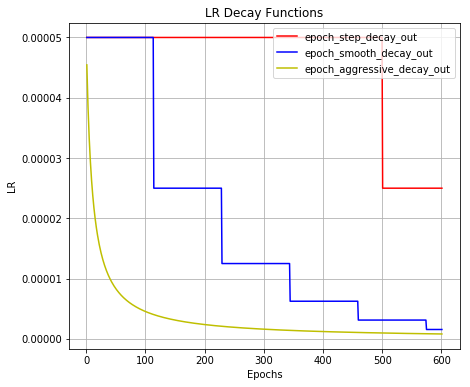

In [11]:
# Plot different learnings rate schedules
%matplotlib inline

epoch_step_decay = lambda epoch: HP.LEARNING_RATE * (0.5**(epoch // HP.LEARNING_RATE_DECAY))
epoch_smooth_decay = lambda epoch: HP.LEARNING_RATE * math.pow(0.5, math.floor((1 + epoch) / 115.0))
epoch_aggressive_decay = lambda epoch: HP.LEARNING_RATE * 1 / (1  + epoch * 1e-1/1 )

epts = np.linspace(1, HP.NUM_EPOCHS+1, HP.NUM_EPOCHS)

epoch_step_decay_out = np.vectorize(epoch_step_decay)(epts)
epoch_smooth_decay_out = np.vectorize(epoch_smooth_decay)(epts)
epoch_aggressive_decay_out = np.vectorize(epoch_aggressive_decay)(epts)

plt.figure(figsize=(7,6))
plt.plot(epts,epoch_step_decay_out, label='epoch_step_decay_out', color='r')
plt.plot(epts,epoch_smooth_decay_out, label='epoch_smooth_decay_out', color='b')
plt.plot(epts,epoch_aggressive_decay_out, label='epoch_aggressive_decay_out', color='y')
plt.title("LR Decay Functions")
plt.xlabel("Epochs");
plt.ylabel("LR");
plt.grid(True)
plt.legend(loc='upper right');

In [12]:
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=HP.LEARNING_RATE, 
                            momentum=HP.NUM_MOMENTUM, 
                            weight_decay=HP.WEIGHT_DECAY, 
                            nesterov=True)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[epoch_smooth_decay])

<IPython.core.display.Javascript object>


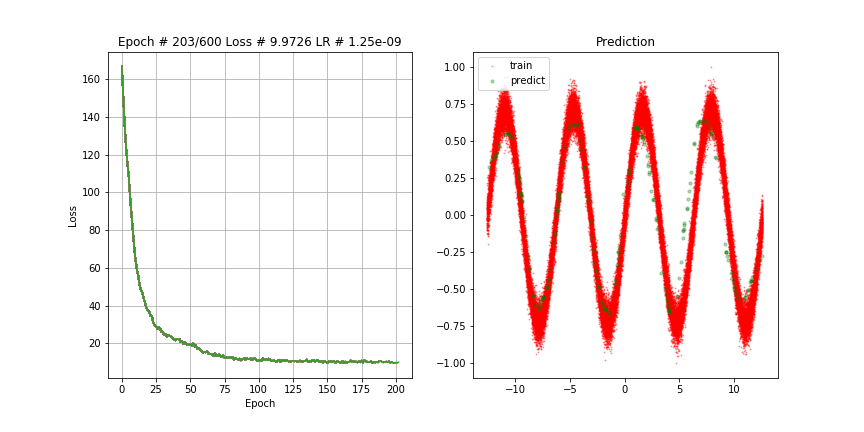

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

SIGINT received. Delaying KeyboardInterrupt.


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


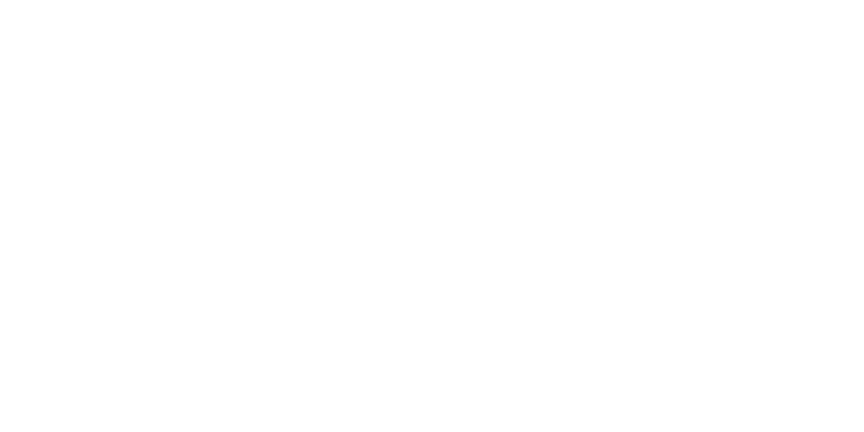

In [13]:
%matplotlib notebook

model.train()

pl = PlotLosses()

losses = []
start = time.time()
epoch_iter = tqdm_notebook(range(1, HP.NUM_EPOCHS + 1))
for epoch in epoch_iter:
    epoch_iter.set_description('Epoch')

    with DelayedKeyboardInterrupt():

        scheduler.step()

        loss_avg = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            y_pred = model(to_var(data, async=True)) # predict y based on x
            loss = criterion(y_pred, to_var(target)) # compute loss

            optimizer.zero_grad() # clear gradients
            loss.backward() # compute gradients
            optimizer.step() # apply gradients

            loss_avg += loss.item()

        loss_avg /= batch_idx+1
        losses.append(loss_avg)

        pl.plot_loss(losses, epoch, HP.NUM_EPOCHS, scheduler.get_lr()[0])
        pl.plot_prediction(train_x, train_y, data.numpy(), to_np(y_pred))

        epoch_iter.set_postfix(loss=loss_avg, lr=scheduler.get_lr()[0])
            
print("Model training took %.2f seconds." % (time.time() - start))

save_checkpoint({
    'model' : type(model).__name__,
    'hyperparameters' : HP,
    'epoch': epoch,
    'loss' : loss.item(),
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict()
},
    filename='./chkp/MLP1-checkpoint.tar')

display(HP)

pl.close()

In [14]:
%matplotlib inline

net = UFA10(test_x.shape[1], HP.NUM_HIDDEN_NODES, test_y.shape[1])

checkpoint = load_checkpoint(net, filename='./chkp/MLP1-checkpoint.tar')
display("Name: " + checkpoint['model'],
        "Epoch: %d" % checkpoint['epoch'],
        "Loss: %.4f" % checkpoint['loss'],
        checkpoint['hyperparameters'])

net.eval()

if torch.cuda.is_available():
    net.cuda()
    
y_pred = []
for data, target in test_loader:
    
    output = net(to_var(data))

    y_pred.append(to_np(output)[0])

y_pred = np.array(y_pred)

=> loaded checkpoint './chkp/MLP1-checkpoint.tar' (epoch 600)


'Name: UFA10'

'Epoch: 600'

'Loss: 3.6685'

{'LEARNING_RATE': 5e-05,
 'LEARNING_RATE_DECAY': 500,
 'MINI_BATCH_SIZE': 200,
 'NUM_EPOCHS': 600,
 'NUM_EXAMPLES': 100000,
 'NUM_HIDDEN_NODES': 95,
 'NUM_MOMENTUM': 0.9,
 'SEED': 2018,
 'TRAIN_SPLIT': 0.8,
 'WEIGHT_DECAY': 0.0005}

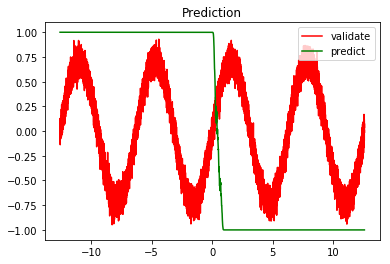

In [15]:
plot_prediction(test_x, test_y, test_x, y_pred, "Prediction", "validate", "predict")

In [ ]:
stat_summary(valid_y.flatten(), y_pred.flatten(), valid_y.shape[0], sum([np.prod(p.size()) for p in net.parameters()]))

In [ ]:
residual_plots(valid_y.flatten(), y_pred.flatten())

In [ ]:
print_summary(model)

In [ ]:
layer_stats(model)

In [ ]:
make_dot(output, net.state_dict())